In [78]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import datetime
import numpy as np
import gc


!pip install -q keras 
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

%matplotlib inline

You should consider upgrading via the 'pip install --upgrade pip' command.


In [79]:
neurons = 512                 
activation_function = 'tanh'  
loss = 'mse'                  
optimizer= 'adam'             
dropout = 0.25                
batch_size = 128              
epochs = 53                  
window_len = 7               
training_size = 0.8          
merge_date = '2016-01-01'     

In [80]:
def get_market_data(market, tag=True):


  market_data = pd.read_html("https://coinmarketcap.com/currencies/" + market + 
                             "/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"), flavor='html5lib')[0]
  market_data = market_data.assign(Date=pd.to_datetime(market_data['Date']))  
  market_data['Volume'] = (pd.to_numeric(market_data['Volume'], errors='coerce').fillna(0))
  if tag:
    market_data.columns = [market_data.columns[0]] + [tag + '_' + i for i in market_data.columns[1:]]
  return market_data


def merge_data(a, b, from_date=merge_date):

  merged_data = pd.merge(a, b, on=['Date'])
  merged_data = merged_data[merged_data['Date'] >= from_date]
  return merged_data


def add_volatility(data, coins=['ETH','LTC']):

  for coin in coins:
    
    kwargs = {coin + '_change': lambda x: (x[coin + '_Close'] - x[coin + '_Open']) / x[coin + '_Open'],
             coin + '_close_off_high': lambda x: 2*(x[coin + '_High'] - x[coin + '_Close']) / (x[coin + '_High'] - x[coin + '_Low']) - 1,
             coin + '_volatility': lambda x: (x[coin + '_High'] - x[coin + '_Low']) / (x[coin + '_Open'])}
    data = data.assign(**kwargs)
  return data


def create_model_data(data):

  
  data = data[['Date']+[coin+metric for coin in ['ETH_','LTC_'] for metric in ['Close**','Volume']]]
  data = data.sort_values(by='Date')
  return data


def split_data(data, training_size=0.8):

  return data[:int(training_size*len(data))], data[int(training_size*len(data)):]


def create_inputs(data, coins=['ETH','LTC'], window_len=window_len):

  norm_cols = [coin + metric for coin in coins for metric in ['_Close**', '_Volume']]
  inputs = []
  for i in range(len(data) - window_len):
    temp_set = data[i:(i + window_len)].copy()
    inputs.append(temp_set)
    for col in norm_cols:
      inputs[i].loc[:, col] = inputs[i].loc[:, col] / inputs[i].loc[:, col].iloc[0] - 1  
  return inputs


def create_outputs(data, coin, window_len=window_len):

  return (data[coin + '_Close**'][window_len:].values / data[coin + '_Close**'][:-window_len].values) - 1


def to_array(data):

  x = [np.array(data[i]) for i in range (len(data))]
  return np.array(x)


def build_model(inputs, output_size, neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):

  model = Sequential()
  model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(Dense(units=output_size))
  model.add(Activation(activ_func))
  model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
  model.summary()
  return model

In [81]:

def show_plot(data, tag):
  fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
  ax1.set_ylabel('Closing Price ($)',fontsize=12)
  ax2.set_ylabel('Volume ($ bn)',fontsize=12)
  ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
  ax2.set_yticklabels(range(10))
  ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
  ax1.set_xticklabels('')
  ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
  ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
  ax1.plot(data['Date'].astype(datetime.datetime),data[tag +'_Open*'])
  ax2.bar(data['Date'].astype(datetime.datetime).values, data[tag +'_Volume'].values)
  fig.tight_layout()
  plt.show()
  

def date_labels():
  last_date = market_data.iloc[0, 0]
  date_list = [last_date - datetime.timedelta(days=x) for x in range(len(X_test))]
  return[date.strftime('%m/%d/%Y') for date in date_list][::-1]


def plot_results(history, model, Y_target, coin):
  plt.figure(figsize=(25, 20))
  plt.subplot(311)
  plt.plot(history.epoch, history.history['loss'], )
  plt.plot(history.epoch, history.history['val_loss'])
  plt.xlabel('Number of Epochs')
  plt.ylabel('Loss')
  plt.title(coin + ' Model Loss')
  plt.legend(['Training', 'Test'])

  plt.subplot(312)
  plt.plot(Y_target)
  plt.plot(model.predict(X_train))
  plt.xlabel('Dates')
  plt.ylabel('Price')
  plt.title(coin + ' Single Point Price Prediction on Training Set')
  plt.legend(['Actual','Predicted'])

  ax1 = plt.subplot(313)
  plt.plot(test_set[coin + '_Close**'][window_len:].values.tolist())
  plt.plot(((np.transpose(model.predict(X_test)) + 1) * test_set[coin + '_Close**'].values[:-window_len])[0])
  plt.xlabel('Dates')
  plt.ylabel('Price')
  plt.title(coin + ' Single Point Price Prediction on Test Set')
  plt.legend(['Actual','Predicted'])
  
  date_list = date_labels()
  ax1.set_xticks([x for x in range(len(date_list))])
  for label in ax1.set_xticklabels([date for date in date_list], rotation='vertical')[::2]:
    label.set_visible(False)

  plt.show()

In [82]:
eth_data = get_market_data("ethereum", tag='ETH')
ltc_data = get_market_data("litecoin", tag='LTC')

In [83]:
ltc_data.head()

,Date,LTC_Open*,LTC_High,LTC_Low,LTC_Close**,LTC_Volume,LTC_Market Cap
0,2019-08-06,96.89,98.98,91.66,93.07,3.245340e+09,5861986121
1,2019-08-05,93.09,105.59,93.09,96.83,4.134353e+09,6098470159
2,2019-08-04,94.60,95.39,91.45,93.20,2.427608e+09,5868857449
3,2019-08-03,95.02,96.84,94.16,94.58,2.512959e+09,5954227577
4,2019-08-02,99.20,99.20,93.54,94.94,2.882784e+09,5975497672


In [84]:
eth_data.head()

,Date,ETH_Open*,ETH_High,ETH_Low,ETH_Close**,ETH_Volume,ETH_Market Cap
0,2019-08-06,234.25,239.12,223.55,226.02,7647742672,24232708406
1,2019-08-05,222.65,235.64,222.60,234.22,7765060287,25108076876
2,2019-08-04,222.58,224.23,218.49,222.67,5238542572,23867371249
3,2019-08-03,217.90,224.62,217.33,222.49,5697798687,23845116864
4,2019-08-02,217.88,222.18,215.98,217.87,6159440229,23347127327


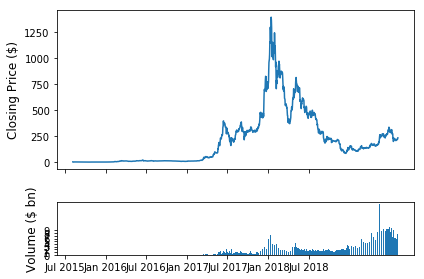

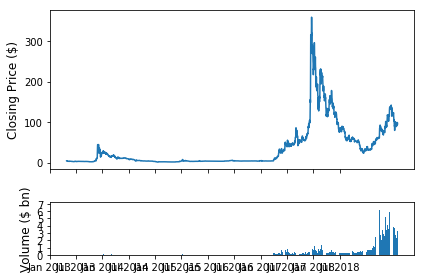

In [85]:
show_plot(eth_data, tag='ETH')
show_plot(ltc_data, tag='LTC')

In [86]:
market_data = merge_data(eth_data, ltc_data)
model_data = create_model_data(market_data)
train_set, test_set = split_data(model_data)

In [87]:
model_data.head()

,Date,ETH_Close**,ETH_Volume,LTC_Close**,LTC_Volume
1313,2016-01-01,0.948024,206062,3.51,2791170.0
1312,2016-01-02,0.937124,255504,3.50,3020260.0
1311,2016-01-03,0.971905,407632,3.48,2406150.0
1310,2016-01-04,0.954480,346245,3.50,3309740.0
1309,2016-01-05,0.950176,219833,3.47,2104650.0


In [88]:
train_set = train_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

X_train = create_inputs(train_set)
Y_train_btc = create_outputs(train_set, coin='ETH')
X_test = create_inputs(test_set)
Y_test_btc = create_outputs(test_set, coin='ETH')

Y_train_eth = create_outputs(train_set, coin='LTC')
Y_test_eth = create_outputs(test_set, coin='LTC')

X_train, X_test = to_array(X_train), to_array(X_test)

print (np.shape(X_train), np.shape(X_test), np.shape(Y_train_btc), np.shape(Y_test_btc))
print (np.shape(X_train), np.shape(X_test), np.shape(Y_train_eth), np.shape(Y_test_eth))

(1044, 7, 4) (256, 7, 4) (1044,) (256,)
(1044, 7, 4) (256, 7, 4) (1044,) (256,)


In [89]:

gc.collect()


np.random.seed(202)


btc_model = build_model(X_train, output_size=1, neurons=neurons)


btc_history = btc_model.fit(X_train, Y_train_btc, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, Y_test_btc), shuffle=False)

W0807 16:00:35.753125 139708914070528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0807 16:00:35.772785 139708914070528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0807 16:00:35.778406 139708914070528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0807 16:00:37.564476 139708914070528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0807 16:00:37.570283 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 512)            1058816   
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 512)            2099200   
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
__________

W0807 16:00:41.327505 139708914070528 deprecation.py:323] From /usr/local/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0807 16:00:42.876650 139708914070528 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 1044 samples, validate on 256 samples
Epoch 1/53
1044/1044 [==============================] - 11s 10ms/step - loss: 0.0482 - mean_absolute_error: 0.1482 - val_loss: 0.0122 - val_mean_absolute_error: 0.0821
Epoch 2/53
1044/1044 [==============================] - 8s 8ms/step - loss: 0.0349 - mean_absolute_error: 0.1242 - val_loss: 0.0076 - val_mean_absolute_error: 0.0662
Epoch 3/53
1044/1044 [==============================] - 8s 8ms/step - loss: 0.0243 - mean_absolute_error: 0.1060 - val_loss: 0.0066 - val_mean_absolute_error: 0.0581
Epoch 4/53
1044/1044 [==============================] - 8s 8ms/step - loss: 0.0207 - mean_absolute_error: 0.0977 - val_loss: 0.0056 - val_mean_absolute_error: 0.0557
Epoch 5/53
1044/1044 [==============================] - 8s 8ms/step - loss: 0.0198 - mean_absolute_error: 0.0932 - val_loss: 0.0058 - val_mean_absolute_error: 0.0529
Epoch 6/53
1044/1044 [==============================] - 8s 8ms/step - loss: 0.0164 - mean_absolute_error: 0.0851 - val_lo

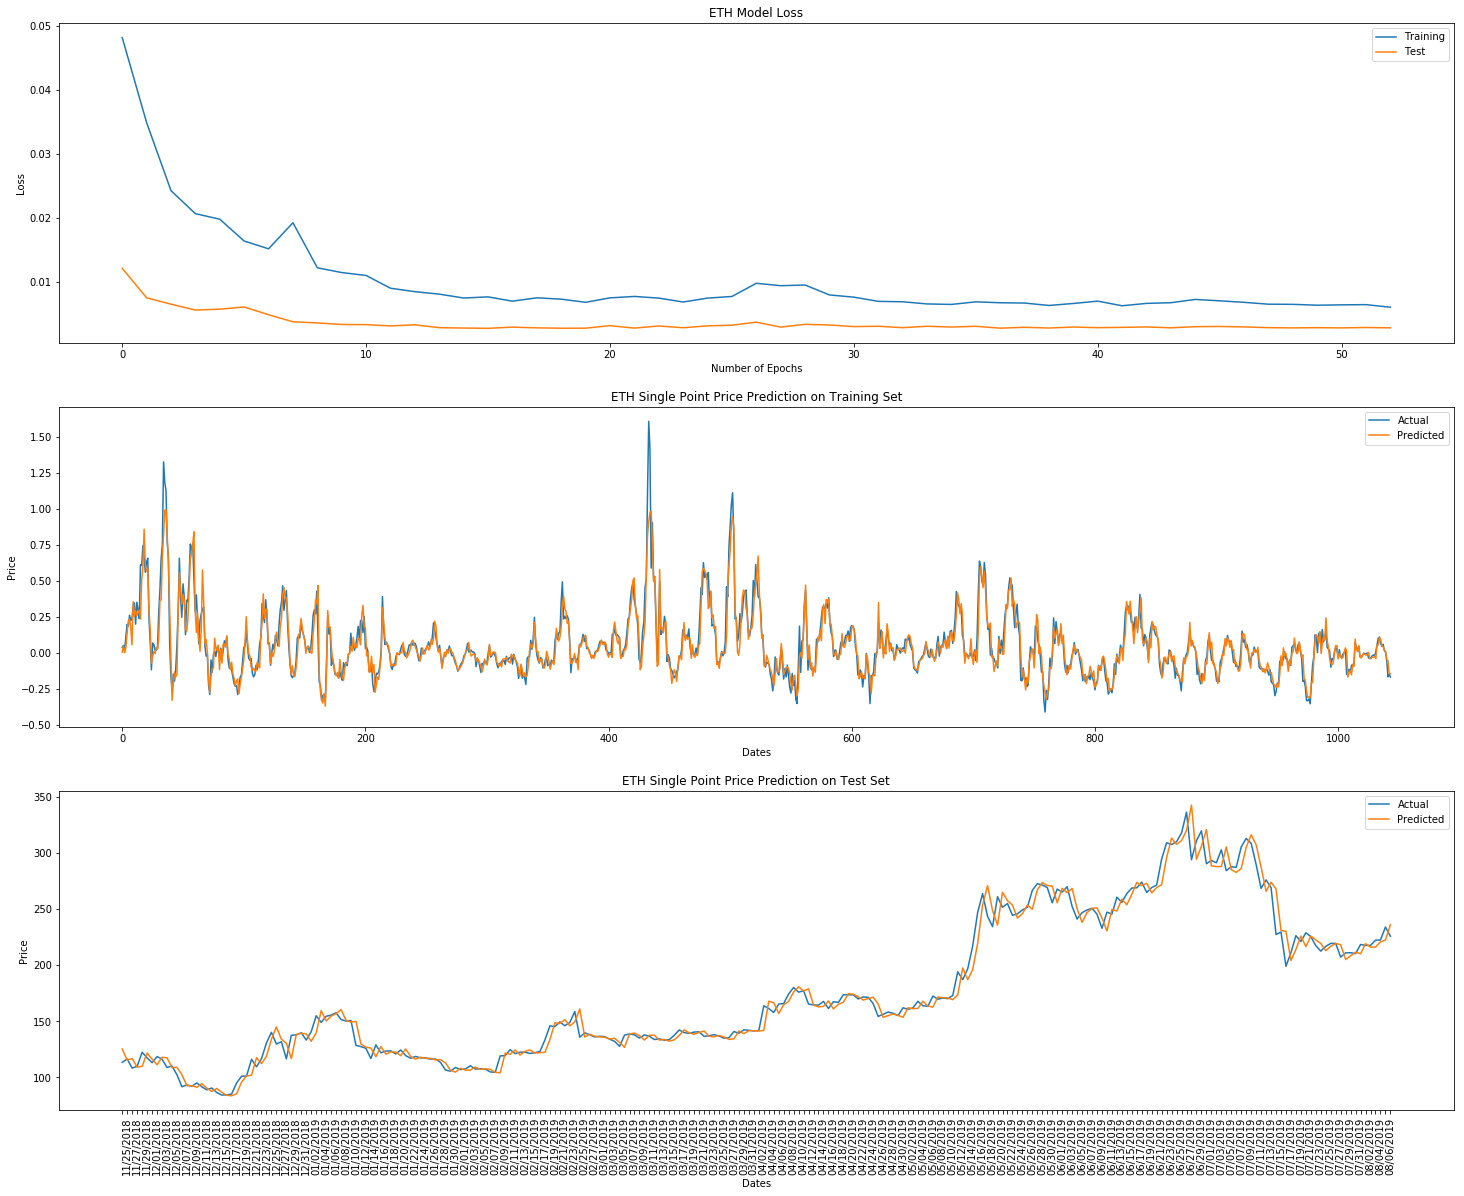

In [90]:
plot_results(btc_history, btc_model, Y_train_btc, coin='ETH')

In [91]:

gc.collect()


np.random.seed(202)


eth_model = build_model(X_train, output_size=1, neurons=neurons)


eth_history = eth_model.fit(X_train, Y_train_eth, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, Y_test_eth), shuffle=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 7, 512)            1058816   
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 7, 512)            2099200   
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 512)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
__________

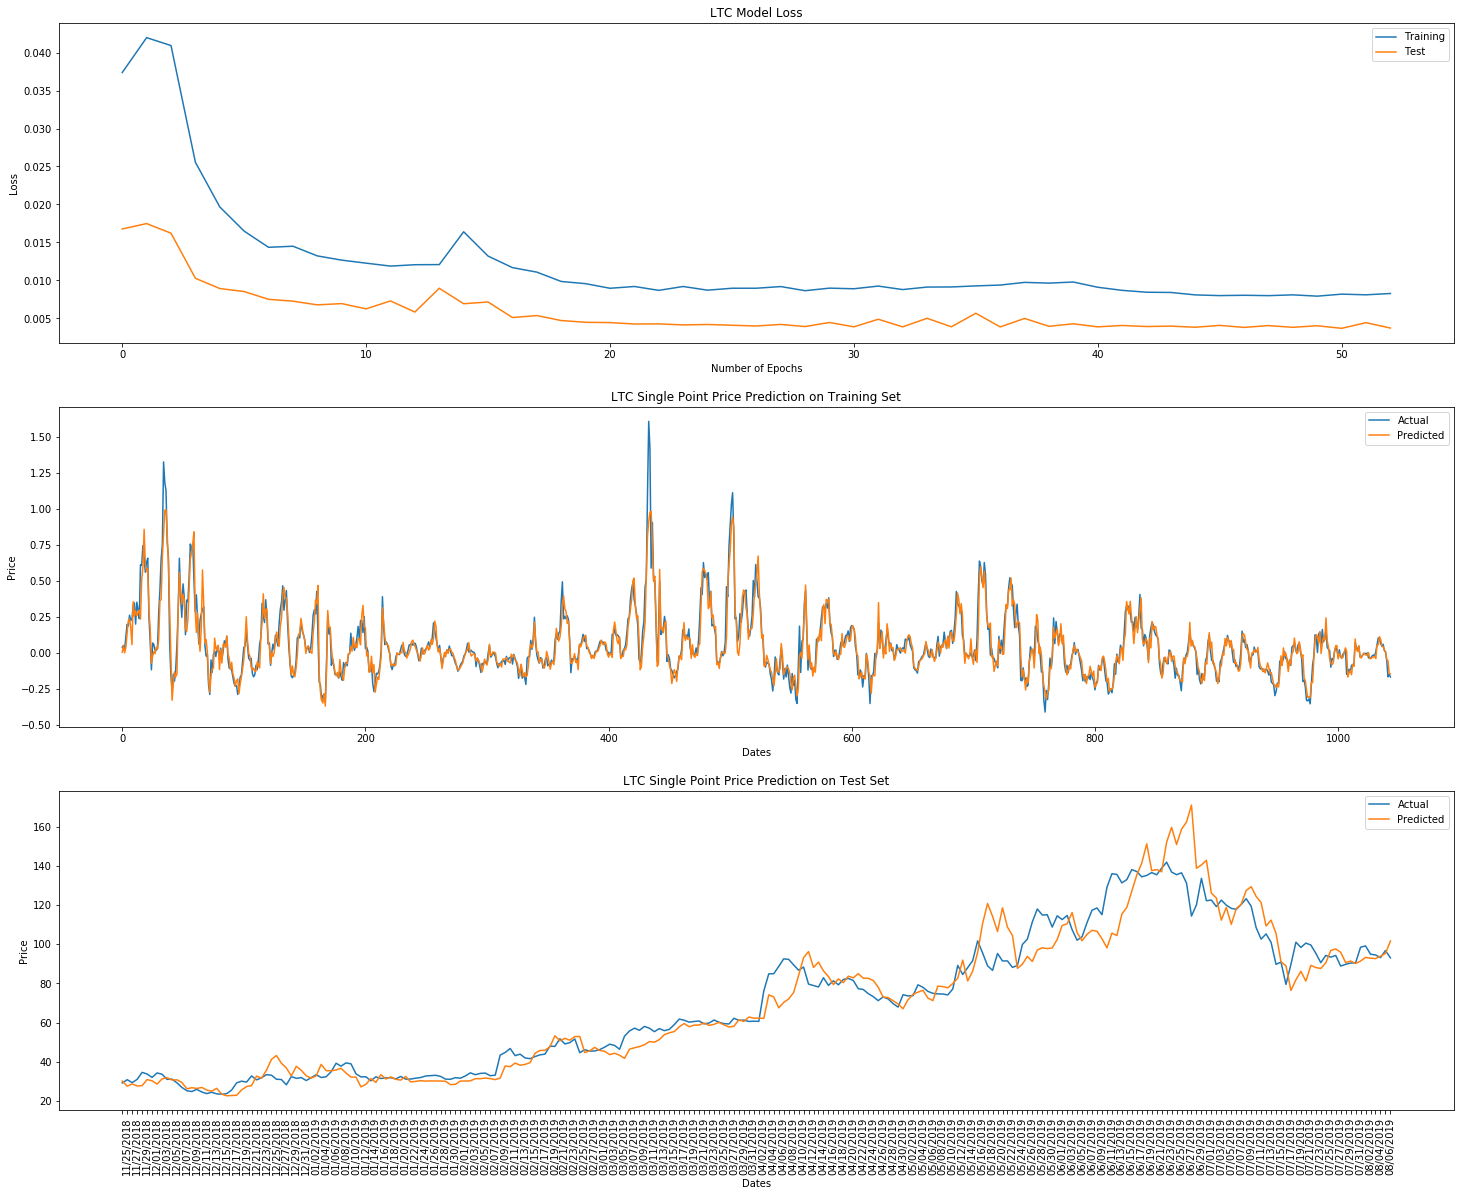

In [92]:
plot_results(eth_history, btc_model, Y_train_btc, coin='LTC')